In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from __future__ import print_function, division
%matplotlib inline

#The Relation between $M_{\rm peak}$ & $V_{\rm peak}$

##Load simulation

In [2]:
from halotools import sim_manager

#load halo catalogue
simname = 'bolshoi_250'
halocat = sim_manager.CachedHaloCatalog(simname = simname, redshift=0.0, dz_tol=0.001,
                                        version_name='custom', halo_finder='Rockstar')

print(halocat.halo_table.dtype.names)
print("number of (sub-)haloes: ", len(halocat.halo_table))

('halo_upid', 'halo_first_acc_mvir', 'halo_acc_scale', 'halo_rvir', 'halo_vpeak', 'halo_macc', 'halo_first_acc_scale', 'halo_mpeak', 'halo_half_mass_scale', 'halo_mvir', 'halo_T/|U|', 'halo_vmax_at_mpeak', 'halo_pid', 'halo_y', 'halo_x', 'halo_z', 'halo_m200b', 'halo_m200c', 'halo_first_acc_vmax', 'halo_mpeak_scale', 'halo_vmax', 'halo_vacc', 'halo_id', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rs', 'halo_nfw_conc', 'halo_hostid', 'halo_mvir_host_halo')
number of (sub-)haloes:  6161686


In [3]:
#define cosmology
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.27) #Bolshoi cosmology

In [4]:
#define some functions

def vmax_model(mass, z, cosmo):
    """
    maximum circular velocity of an NFW profile
    eq. 5 van den Bosch + 2014
    
    Parameters
    ----------
    mass : array_like
        array of halo masses
    
    z : array_like
        array of redshifts
        
    cosmo : astropy.cosmology object
        astropy comology object indicating cosmology
    """
    def f(x):
        return np.log(1.0+x) - x/(1.0+x)
    
    def virial_velocity(mass, cosmo, z):
        """
        virial velocity
        eq. 6 van den Bosch + 2014
        """
        return 159.43 * (mass/10.0**12)**(1.0/3.0)*\
               (cosmo.H(z)/cosmo.H0)**(1.0/3.0)*\
               (dvir(z, cosmo)/178.0)**(1.0/6.0)
    
    def dvir(z, cosmo):
        """
        critical density for closure
        """
        x = cosmo.Om(z)-1.0
        return 18.0*np.pi**2 + 82.0*x - 39.0*x**2
    
    def concentration(mass, z):
        """
        median concentration as a function of mass and redshift
        eq. B2, Jiang + 2016
        """
        return 4.67/(1.0 + z)*(mass/(10**14.0))**(-0.11)
    
    c = concentration(mass, z)   
    return 0.465 * virial_velocity(mass, cosmo, z) * np.sqrt(c/f(c))

def vpeak_model(mass, z, cosmo):
    """
    Calculate the mean peak velocity
    
    Parameters
    ----------
    mass : array_like
        array of halo masses
    
    z : array_like
        array of redshifts
        
    cosmo : astropy.cosmology object
        astropy comology object indicating cosmology
    """
    return vmax_model(mass, z, cosmo)*1.1

#interpolate mpeak vpeak relation
msample = np.logspace(8,16,80)
zsample = np.linspace(0,10,50)
vsample = np.logspace(1,4,100)

from scipy.interpolate import interp1d, interp2d

result = np.zeros((len(zsample),len(vsample)))
for i,z in enumerate(zsample):
        vs = vpeak_model(msample, z, cosmo)
        f = interp1d(vs, msample, fill_value='extrapolate')
        for j,v in enumerate(vsample):
            result[i,j] = f(v)

In [ ]:
"""
Find empirical relation between Mpeak vs Vpeak in Bolshoi
"""

m = halocat.halo_table['halo_mpeak']
v = halocat.halo_table['halo_vpeak']
a = halocat.halo_table['halo_acc_scale']

#seperate for host-haloes and sub-haloes
host = (halocat.halo_table['halo_upid']==-1)
sub = (halocat.halo_table['halo_upid']!=-1)

#calculate the scatter in vpeak as a function of mpeak
from halotools.mock_observables import mean_y_vs_x
from scipy.stats import binned_statistic
bins = np.arange(10,15,0.25)

x = np.log10(m)
y = np.log10(v)
#all
log_bin_centers, log_mean_v, log_sigma_v = mean_y_vs_x(x, y,
    bins=bins, error_estimator='variance')

#host-haloes
log_bin_centers, log_mean_v_host, log_sigma_v_host = mean_y_vs_x(x[host], y[host],
    bins=bins, error_estimator='variance')

#sub-haloes
log_bin_centers, log_mean_v_sub, log_sigma_v_sub = mean_y_vs_x(x[sub], y[sub],
    bins=bins, error_estimator='variance')

#translate to non-log errors
err_lower = 10**(log_mean_v_host) - 10**(log_mean_v_host-(log_sigma_v_host))
err_upper = 10**(log_mean_v_host+(log_sigma_v_host)) - 10**(log_mean_v_host)
err = np.vstack((err_lower,err_upper))

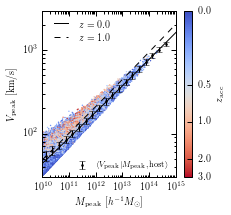

In [23]:
"""
Make figure showing Mpeak vs Vpeak
"""

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)

#scatter plot
redshifts = 1.0/a - 1.0
plt.scatter(m[sub] ,v[sub], c = a[sub], lw=0, s=2,
            rasterized=True, cmap = 'coolwarm_r', vmin=0.25, vmax=1.0)
#mean relations
msample = np.logspace(9,16,100)
p1, = plt.plot(msample, vpeak_model(msample, 0.0, cosmo),
               '-', color='black', alpha=1.0)
p2, = plt.plot(msample, vpeak_model(msample, 1.0/0.5-1.0, cosmo),
               '--', color='black', alpha=1.0)
p3 = plt.errorbar(10.0**log_bin_centers, 10.0**log_mean_v_host, yerr = err,
                  color='black', fmt='o', ms=2)
plt.xscale('log')
plt.yscale('log')
plt.ylim([30,3000])
plt.xlim([10**10,10**15])
plt.xlabel(r'$M_{\rm peak} ~[h^{-1}M_{\odot}]$')
plt.ylabel(r'$V_{\rm peak} ~ [{\rm km/s}]$')
first_legend = plt.legend((p1,p2),(r'$z=0.0$',r'$z=1.0$'),
                          fontsize=10, frameon=False, loc='upper left')
ax = plt.gca().add_artist(first_legend)
plt.legend([p3],[r'$\langle V_{\rm peak} | M_{\rm peak}, {\rm host} \rangle $'],
           frameon = False, fontsize=8, loc='lower right', numpoints=1)

#colorbar
cbar = plt.colorbar()
cbar.set_label(r'$z_{\rm acc}$')
redshifts = np.array([0.0,0.5,1.0,2.0,3.0])
scales = 1.0/(1+redshifts)
cbar.set_ticks(scales)
cbar.set_ticklabels(redshifts)
plt.show()

filepath = './figures/'
filename = 'mpeak_vs_vpeak'
fig.savefig(filepath+filename+'.pdf', dpi=300)

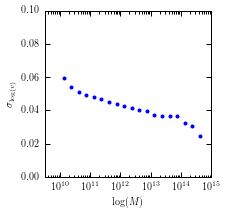

In [11]:
"""
examine the scatter in the relaton
"""

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.plot(10**log_bin_centers, log_sigma_v, 'o', mec='none', ms=4)
plt.xlim([10**9.5,10**15])
plt.xscale('log')
plt.ylim([0,0.1])
plt.ylabel(r'$\sigma_{\log(v)}$')
plt.xlabel(r'$\log(M)$')
plt.show()